In [1]:
# import keras
import keras

Using TensorFlow backend.


In [2]:
from google.colab import drive

drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
Path = '/content/drive/My Drive/Colab Notebooks/Advanced Computer Vision/Data/hackathon'

In [0]:
train_labels_path = Path + '/train_labels.csv'

In [0]:
test_labels_path = Path + '/test_labels_students.xlsx'

In [0]:
from zipfile import ZipFile

filename = '/content/drive/My Drive/Colab Notebooks/Advanced Computer Vision/Data/hackathon/images.zip'
with ZipFile(filename) as z:
  z.extractall()

In [0]:
from zipfile import ZipFile

filename = '/content/drive/My Drive/Colab Notebooks/Advanced Computer Vision/Data/hackathon/annotations_train.zip'
with ZipFile(filename) as z:
  z.extractall()

In [0]:
import csv
with open(train_labels_path, 'r') as csvfile:
    images = []
    annotations = []
    train_labels = []
    reader = csv.reader(csvfile, delimiter=',')
    csvfile.seek(0)
    for col, row in enumerate(reader):
               
        #for i, r in enumerate(row[1:3]): # Parse row with seven entities
            #row[i+1] = int(r)
            #print(i)  
            path, annotation, label = row
            path = path.split('/')[-1]
            images.append(path)
            annotations.append(annotation)
            train_labels.append(label)

In [0]:
images = images[1:]

In [60]:
len(images)

4346

In [0]:
annotations = annotations[1:]

In [62]:
len(annotations)

4346

In [0]:
train_labels = train_labels[1:]

In [64]:
len(train_labels)

4346

In [0]:
import xlrd
#with open(test_labels_path, 'r') as csvfile:
test_images = []
test_ID = []
wb = xlrd.open_workbook(test_labels_path)
sheet = wb.sheet_by_index(0)
for i in range(sheet.nrows):
            
    #for i, r in enumerate(row[1:3]): # Parse row with seven entities
        #row[i+1] = int(r)
        #print(i)  
        path = sheet.cell_value(i,1)
        path = path.split('/')[-1]
        test_images.append(path)
        test_ID.append(sheet.cell_value(i,0))

In [71]:
len(test_images)

1864

In [0]:
test_images = test_images[1:]

In [0]:
test_ID = test_ID[1:]

In [0]:
import scipy.io as sc

In [0]:
train_an=[]
train_con=[]
for i in annotations:
  an = sc.loadmat(i)
  train_an.append(an['box_coord'][0])
  train_con.append(an['obj_contour'][0])

In [0]:
coords = np.zeros((len(train_an),4))

In [0]:
for i,r in enumerate(train_an):
  #print(i)
  #print(r)
  coords[i][0]=r[0]
  coords[i][1]=r[1]
  coords[i][2]=r[2]
  coords[i][3]=r[3]

In [122]:
coords

array([[  8., 164.,  15., 286.],
       [  3., 299.,   3., 294.],
       [ 22., 284.,  34., 198.],
       ...,
       [ 10., 265.,  31., 283.],
       [ 21., 151.,  11., 294.],
       [ 33., 285.,  20., 183.]])

In [0]:
for i in range(len(images)):

  unscaled = cv2.imread(images[i]) # Original image for display
  image_height, image_width, _ = unscaled.shape
  coords[i][0]= coords[i][0] * IMAGE_SIZE / image_width
  coords[i][1]=coords[i][0] * IMAGE_SIZE / image_height
  coords[i][2]=coords[i][0] * IMAGE_SIZE / image_width
  coords[i][3]=coords[i][0] * IMAGE_SIZE / image_height

In [141]:
coords

array([[ 3.41333333,  1.45635556,  1.45635556,  1.45635556],
       [ 1.29292929,  0.55722205,  0.55722205,  0.55722205],
       [11.6846473 ,  6.20595375,  6.20595375,  6.20595375],
       ...,
       [ 4.26666667,  1.82044444,  1.82044444,  1.82044444],
       [ 8.96      ,  3.82293333,  3.82293333,  3.82293333],
       [21.33333333, 13.79124579, 13.79124579, 13.79124579]])

In [0]:
# IMPORT LIBRARIES AND PACKAGES
import tensorflow as tf
import csv
import numpy as np
from PIL import Image

from keras import Model
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from keras.utils import Sequence
from keras.backend import epsilon

In [0]:
# SETTINGS

ALPHA = 1.0 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower

IMAGE_SIZE = 128 # MobileNet takes images of size 128*128*3 

EPOCHS = 5 # Number of epochs. I got decent performance with just 5.
BATCH_SIZE = 32 # Depends on your GPU or CPU RAM.

In [127]:
batch_images = np.zeros((len(images), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
print("First few paths",images[0],images[1])
for i, f in enumerate(images):
    try :
      img = Image.open(f) # Read image
      img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
      img = img.convert('RGB')
      batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))
    except :
      pass

First few paths 3917.jpg 5368.jpg


In [128]:
batch_images.shape

(4346, 128, 128, 3)

In [129]:
model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA) # Load pre-trained mobilenet
# Do not include classification (top) layer

# to freeze layers, except the new top layer, of course, which will be added below
for layer in model.layers:
    layer.trainable = False

# Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
x = model.layers[-1].output
x = Conv2D(4, kernel_size=4, name="coords")(x)
# In the line above kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
x = Reshape((4,))(x) # These are the 4 predicted coordinates of one BBox

model = Model(inputs=model.input, outputs=x)

W0809 08:45:53.491885 140441550391168 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0809 08:45:53.541585 140441550391168 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0809 08:45:53.551600 140441550391168 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0809 08:45:53.599536 140441550391168 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0809 08:45:53.600476 1404415503

17227776/17225924 [==============================] - 1s 0us/step


In [0]:
gt = coords
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_func(loss, [y_true, y_pred], tf.float32)
    return iou

In [143]:
coords

array([[ 3.41333333,  1.45635556,  1.45635556,  1.45635556],
       [ 1.29292929,  0.55722205,  0.55722205,  0.55722205],
       [11.6846473 ,  6.20595375,  6.20595375,  6.20595375],
       ...,
       [ 4.26666667,  1.82044444,  1.82044444,  1.82044444],
       [ 8.96      ,  3.82293333,  3.82293333,  3.82293333],
       [21.33333333, 13.79124579, 13.79124579, 13.79124579]])

In [152]:
model.compile(optimizer='Adam', loss='mse', metrics=[IoU]) # Regression loss is MSE

#checkpoint = ModelCheckpoint("model-{val_iou:.2f}.h5", verbose=1, save_best_only=True,
#                              save_weights_only=True, mode="max", period=1) # Checkpoint best validation model
#stop = EarlyStopping(monitor="val_iou", patience=PATIENCE, mode="max") # Stop early, if the validation error deteriorates
#reduce_lr = ReduceLROnPlateau(monitor="val_iou", factor=0.2, patience=10, min_lr=1e-7, verbose=1, mode="max")
# Reduce learning rate if Validation IOU does not improve

model.fit(batch_images,gt,
            epochs=100,batch_size = 32,
            verbose=1)

Epoch 1/100
4346/4346 [==============================] - 5s 1ms/step - loss: 45.1559 - IoU: 0.2162
Epoch 2/100
4346/4346 [==============================] - 4s 985us/step - loss: 29.9194 - IoU: 0.2278
Epoch 3/100
4346/4346 [==============================] - 4s 986us/step - loss: 23.9972 - IoU: 0.2570
Epoch 4/100
4346/4346 [==============================] - 4s 994us/step - loss: 20.3232 - IoU: 0.2750
Epoch 5/100
4346/4346 [==============================] - 4s 982us/step - loss: 18.2193 - IoU: 0.3006
Epoch 6/100
4346/4346 [==============================] - 4s 979us/step - loss: 18.9663 - IoU: 0.3125
Epoch 7/100
4346/4346 [==============================] - 4s 986us/step - loss: 17.8460 - IoU: 0.3256
Epoch 8/100
4346/4346 [==============================] - 4s 985us/step - loss: 15.1022 - IoU: 0.3522
Epoch 9/100
4346/4346 [==============================] - 4s 986us/step - loss: 14.4409 - IoU: 0.3699
Epoch 10/100
4346/4346 [==============================] - 4s 985us/step - loss: 14.0791 - IoU

In [0]:
# Pick a test image, run model, show image, and show predicted bounding box overlaid on the image
import cv2

filename = "5305.jpg"
unscaled = cv2.imread(filename) # Original image for display

In [0]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image to run the network
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

In [162]:
model.predict(x=np.array([feat_scaled]))

array([[-1.8489653, -3.089491 , -2.9009328, -3.1710944]], dtype=float32)

In [163]:
region = model.predict(x=np.array([feat_scaled]))[0] # Predict the BBox
print(region)

[-1.8489653 -3.089491  -2.9009328 -3.1710944]


In [0]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[0] + region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[1] + region[3]) * image_height / IMAGE_SIZE)

In [0]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

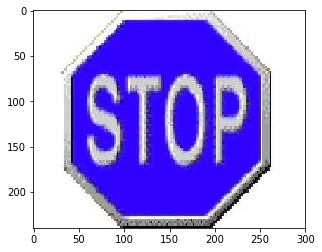

In [166]:
# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

In [0]:
prediction = np.zeros((len(test_images),4))
for i in range(len(test_images)):
  filename = test_images[i]
  #print(filename)
  unscaled = cv2.imread(filename) # Original image for display
  image_height, image_width, _ = unscaled.shape
  image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image to run the network
  feat_scaled = preprocess_input(np.array(image, dtype=np.float32))
  region = model.predict(x=np.array([feat_scaled]))[0]
  x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
  y0 = int(region[1] * image_height / IMAGE_SIZE)

  x1 = int((region[0] + region[2]) * image_width / IMAGE_SIZE)
  y1 = int((region[1] + region[3]) * image_height / IMAGE_SIZE)
  prediction[i][0]=x0
  prediction[i][1]=y0
  prediction[i][2]=x1
  prediction[i][3]=y1

In [0]:
np.savetxt("./prediction.csv", prediction, delimiter=",")

In [178]:
prediction.shape

(1863, 4)

In [0]:
#Importing necessary libraries
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout,Conv2D, Conv2DTranspose
from keras.layers.core import Lambda, RepeatVector, Reshape
#from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, LeakyReLU

In [0]:
X_VGG = []
y_label = []

for n in images:
  #k = imagelist.index(n)
  ##Add image_path    
  #image_path = 
  img = cv2.imread(n)
  img_resize = cv2.resize(img, (224, 224)) 
  X_VGG.append(img_resize)

In [0]:
X_VGG_test = []
#y_label = []

for n in test_images:
  #k = imagelist.index(n)
  ##Add image_path    
  #image_path = 
  img = cv2.imread(n)
  img_resize = cv2.resize(img, (224, 224)) 
  X_VGG_test.append(img_resize)

In [0]:
X_VGG_test=np.array(X_VGG_test)

In [187]:
X_VGG.shape

(4346, 224, 224, 3)

In [0]:
y_label=train_labels

In [0]:
y_label=np.array(y_label)

In [192]:
y_label.shape

(4346,)

In [0]:
y_label=np.array(y_label).reshape(4346,1)

In [0]:
X_train_VGG, X_test_VGG, y_train_VGG, y_test_VGG = train_test_split(X_VGG,y_label, test_size = 0.2, random_state = 10)

In [0]:
del X_VGG
del y_label

In [0]:
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import cv2

In [198]:
label_encoder = LabelEncoder()
y_encoded_train = label_encoder.fit_transform(y_train_VGG)
y_encoded_test = label_encoder.fit_transform(y_test_VGG)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
trainY_VGG = tf.keras.utils.to_categorical(y_encoded_train, num_classes=None,dtype='int')

In [0]:
del y_encoded_train

In [0]:
testY_VGG = tf.keras.utils.to_categorical(y_encoded_test, num_classes=None,dtype='int')

In [209]:
testY_VGG.shape

(870, 97)

In [0]:
del y_encoded_test

In [0]:
from keras.applications.vgg16 import preprocess_input

In [0]:
X_VGG_test_P = preprocess_input(X_VGG_test)

In [0]:
X_test_VGG_P = preprocess_input(X_test_VGG)

In [0]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [207]:
!pip install pandas_ml
from pandas_ml import ConfusionMatrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from keras.applications.vgg19 import VGG19, preprocess_input

     |████████████████████████████████| 102kB 6.0MB/s 


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [210]:
# we initialize the model
VGG19_model = Sequential()

# Conv Block 1
VGG19_model.add(Conv2D(64, (3, 3), input_shape=(224,224,3), activation='relu', padding='same'))
VGG19_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
VGG19_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Conv Block 2
VGG19_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
VGG19_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
VGG19_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Conv Block 3
VGG19_model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
VGG19_model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
VGG19_model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
VGG19_model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
VGG19_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
VGG19_model.add(Dropout(0.1))

# Conv Block 4
VGG19_model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
VGG19_model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
VGG19_model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
VGG19_model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
VGG19_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
VGG19_model.add(Dropout(0.2))

# Conv Block 5
VGG19_model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
VGG19_model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
VGG19_model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
VGG19_model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
VGG19_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
VGG19_model.add(Dropout(0.3))

# FC layers 1
VGG19_model.add(Flatten())
VGG19_model.add(Dense(4096, activation='relu'))
VGG19_model.add(Dense(4096, activation='relu'))
VGG19_model.add(Dropout(0.1))

# FC layers 2
VGG19_model.add(Dense(1024, activation='relu'))
VGG19_model.add(Dense(512, activation='relu'))
VGG19_model.add(Dense(256, activation='relu'))

#Softmax
VGG19_model.add(Dense(97, activation='softmax'))

W0809 09:55:18.736627 140441550391168 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0809 09:55:18.837408 140441550391168 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

In [0]:
VGG19_model.compile(optimizer=sgd,loss='categorical_crossentropy', metrics=['accuracy'])

In [215]:
#Train the model
checkpoint = ModelCheckpoint("VGG19-{epoch:03d}.h5",monitor='val_acc', verbose=1, save_best_only=True,
                             save_weights_only=True, mode="auto", period=1) # Checkpoint best validation model
stop = EarlyStopping(monitor='val_acc',patience=50, mode="auto",verbose=1) # Stop early, if the validation error deteriorates
VGG19_model.fit(X_train_VGG_P,trainY_VGG,          
          validation_data=(X_test_VGG_P,testY_VGG),
          epochs=50,
          batch_size=64,
          callbacks=[checkpoint, stop])

W0809 09:57:21.191778 140441550391168 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 3476 samples, validate on 870 samples
Epoch 1/50
3476/3476 [==============================] - 148s 42ms/step - loss: 4.5484 - acc: 0.0299 - val_loss: 4.5382 - val_acc: 0.0448

Epoch 00001: val_acc improved from -inf to 0.04483, saving model to VGG19-001.h5
Epoch 2/50
3476/3476 [==============================] - 123s 35ms/step - loss: 4.5129 - acc: 0.0311 - val_loss: 4.4844 - val_acc: 0.0276

Epoch 00002: val_acc did not improve from 0.04483
Epoch 3/50
3476/3476 [==============================] - 122s 35ms/step - loss: 4.5092 - acc: 0.0334 - val_loss: 4.5336 - val_acc: 0.0448

Epoch 00003: val_acc did not improve from 0.04483
Epoch 4/50
3476/3476 [==============================] - 122s 35ms/step - loss: 4.5014 - acc: 0.0351 - val_loss: 4.5024 - val_acc: 0.0448

Epoch 00004: val_acc did not improve from 0.04483
Epoch 5/50
3476/3476 [==============================] - 122s 35ms/step - loss: 4.4756 - acc: 0.0400 - val_loss: 4.4434 - val_acc: 0.0517

Epoch 00005: val_acc improved fr

KeyboardInterrupt: ignored

In [0]:
from keras.optimizers import SGD

In [0]:
# Instantiate the model with the pre-trained weights (no top)
weight_path = "./drive/My Drive/Colab Notebooks/Computer Vision with CNNs/Data/"
base_model= VGG16(weights=(weight_path+'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'),include_top=False, pooling='avg')

In [0]:
X_train_conv = base_model.predict(X_train_VGG_P)

In [0]:
X_test_conv = base_model.predict(X_test_VGG_P)

In [0]:
X_conv_test = base_model.predict(X_VGG_test_P)

In [0]:
model_tf = tf.keras.models.Sequential()

In [0]:
#Flatten the output
model_tf.add(tf.keras.layers.Flatten())

In [230]:
#Dense layer
model_tf.add(tf.keras.layers.Dense(1024, activation='relu'))

W0809 11:20:29.089942 140441550391168 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
#Dense layer
model_tf.add(tf.keras.layers.Dense(256, activation='relu'))

In [0]:
#Output layer
model_tf.add(tf.keras.layers.Dense(97, activation='softmax'))

In [0]:
for layer in base_model.layers:
  layer.trainable = False

In [0]:
model_tf.compile(optimizer='adam', 
              loss='categorical_crossentropy', metrics=['accuracy'])

In [235]:
#Train the model
model_tf.fit(X_train_conv,trainY_VGG,          
          validation_data=(X_test_conv,testY_VGG),
          epochs=100,
          batch_size=128)

Train on 3476 samples, validate on 870 samples
Epoch 1/100
3476/3476 [==============================] - 1s 180us/sample - loss: 2.8675 - acc: 0.4384 - val_loss: 1.0894 - val_acc: 0.7207
Epoch 2/100
3476/3476 [==============================] - 0s 42us/sample - loss: 0.5631 - acc: 0.8444 - val_loss: 0.7161 - val_acc: 0.8115
Epoch 3/100
3476/3476 [==============================] - 0s 43us/sample - loss: 0.2213 - acc: 0.9442 - val_loss: 0.6186 - val_acc: 0.8414
Epoch 4/100
3476/3476 [==============================] - 0s 44us/sample - loss: 0.0985 - acc: 0.9793 - val_loss: 0.5757 - val_acc: 0.8460
Epoch 5/100
3476/3476 [==============================] - 0s 44us/sample - loss: 0.0344 - acc: 0.9960 - val_loss: 0.5295 - val_acc: 0.8667
Epoch 6/100
3476/3476 [==============================] - 0s 44us/sample - loss: 0.0140 - acc: 0.9997 - val_loss: 0.4942 - val_acc: 0.8747
Epoch 7/100
3476/3476 [==============================] - 0s 51us/sample - loss: 0.0066 - acc: 1.0000 - val_loss: 0.4876 - va

In [0]:
#Prediction
prediction=model_tf.predict(X_test_conv)

In [0]:
prediction = np.argmax(prediction,axis=1)

In [0]:
testY_S = np.argmax(testY_VGG,axis=1)

In [240]:
print(classification_report(testY_S, prediction))
print(confusion_matrix(testY_S, prediction))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        24
           1       1.00      1.00      1.00         8
           2       1.00      0.83      0.91         6
           3       0.92      0.85      0.88        13
           4       0.85      0.92      0.88        12
           5       1.00      0.86      0.92         7
           6       1.00      0.83      0.91         6
           7       1.00      1.00      1.00        11
           8       0.92      1.00      0.96        12
           9       1.00      1.00      1.00         5
          10       0.88      0.70      0.78        10
          11       1.00      0.93      0.97        15
          12       0.50      0.67      0.57         3
          13       0.57      0.80      0.67         5
          14       0.88      1.00      0.93         7
          15       0.50      0.50      0.50         6
          16       0.50      0.62      0.56         8
          17       0.67    

In [246]:
X_VGG_test_P.shape

(1863, 224, 224, 3)

In [0]:
#Prediction
prediction=model_tf.predict(X_conv_test)

In [249]:
prediction

array([[2.1376629e-12, 7.9106027e-12, 3.7012005e-09, ..., 1.4577992e-11,
        1.3368718e-11, 7.3247219e-13],
       [2.2329083e-14, 4.0610276e-14, 3.6994546e-11, ..., 4.4050560e-16,
        4.8094063e-11, 4.1449847e-12],
       [2.2427383e-13, 3.7936295e-16, 3.4688955e-12, ..., 3.8769585e-10,
        4.1035765e-11, 8.7271403e-16],
       ...,
       [8.8000520e-25, 5.6274336e-15, 1.7845687e-17, ..., 1.7482244e-24,
        2.0882414e-19, 8.4647094e-16],
       [1.6384731e-17, 3.0316742e-14, 1.6083090e-13, ..., 1.2585055e-17,
        2.5529648e-10, 1.7470268e-06],
       [1.6584778e-10, 6.2233565e-09, 9.1543120e-09, ..., 4.4568201e-13,
        1.1779575e-04, 6.9349959e-08]], dtype=float32)

In [0]:
prediction = np.argmax(prediction,axis=1)

In [251]:
prediction

array([76, 51, 47, ..., 87, 39, 53])

In [0]:
np.savetxt("./pred.csv", prediction, delimiter=",")